In [42]:
%matplotlib inline

import os
import pysrt # pip install pysrt
import ass # pip install ass
from collections import namedtuple
import itertools
import pandas as pd
import shutil

import numpy as np
from scipy.spatial.distance import cdist
import matplotlib
from matplotlib import pyplot as plt
matplotlib.style.use("ggplot")

In [2]:
DATA_DIR_EN = "/Users/dennybritz/Downloads/daddicts_subs_clean/en"
DATA_DIR_JA = "/Users/dennybritz/Downloads/daddicts_subs_clean/ja"

In [3]:
def parse_sub(filename):
  if filename.endswith(".ass"):
    with open(filename) as f:
      subs = ass.parse(f)
    return ("ASS", subs)
  elif filename.endswith(".srt"):
    subs = pysrt.open(filename, error_handling=2)
    return ("SRT", subs)
  else:
    return None      

In [4]:
def get_subs(directory):
  """Returns an iterator of (name, type) for all files in a directory.
  """
  for filename in os.listdir(directory):
    full_path = os.path.join(directory, filename)
    res = parse_sub(full_path)
    if res is not None:
      yield (full_path, res)

In [5]:
ja_subs_dict = dict(list(get_subs(DATA_DIR_JA)))
en_subs_dict = dict(list(get_subs(DATA_DIR_EN)))

In [6]:
print("Parsed {} Japanese subs".format(len(ja_subs_dict)))
print("Parsed {} English subs".format(len(en_subs_dict)))

Parsed 4328 Japanese subs
Parsed 10980 English subs


In [7]:
# All subs are converted to arrays of this
SubEvent = namedtuple("SubEvent", ["start_sec", "end_sec", "text"])

In [8]:

def any_format_to_sub_events(format_and_subs):
  format_str, subs = format_and_subs
  events = []
  if format_str == "ASS":
    for ass_event in subs.events:
      if not ass_event.TYPE == ass.document.Dialogue.TYPE:
        continue
      e = SubEvent(ass_event.start.total_seconds(), ass_event.end.total_seconds(), ass_event.text)
      events.append(e)
  elif format_str == "SRT":
    for srt_event in subs:
      e = SubEvent(srt_event.start.ordinal/1000.0, srt_event.end.ordinal/1000.0, srt_event.text_without_tags)
      events.append(e)
  return events

In [9]:
# Convert all SRT/ASS subs to SubEvent instances
ja_events = { k: any_format_to_sub_events(v) for k, v in ja_subs_dict.items() }
en_events = { k: any_format_to_sub_events(v) for k, v in en_subs_dict.items() }

In [10]:
ja_events = { k: v for k, v in ja_events.items() if len(v) > 0 }
en_events = { k: v for k, v in en_events.items() if len(v) > 0 }

In [11]:
print("Parsed {} Japanese subs".format(len(ja_events)))
print("Parsed {} English subs".format(len(en_events)))

Parsed 4328 Japanese subs
Parsed 10980 English subs


In [12]:
# Create vector representation
# The feature vector is 1 whenever someone is talking, 0 otherwise
# It "-1" before the first text appears, and -1 after the last text
# to discourage matching buggy subs that start after severa hours
def create_representation(sub_events, max_time=10000):
  """Creates a vector representation of the sub events"""
  res = np.zeros(max_time)
  for e in sub_events:
    if round(e.start_sec) < max_time:
      start_idx = round(e.start_sec)
      end_idx = round(e.end_sec)
      res[start_idx:end_idx] = 1.0
  
  # Set everything before first text to -1
  first_idx = round(sub_events[0].start_sec)
  res[:first_idx] = -1.0
  
  # Set everything after last text to -1
  last_idx = round(sub_events[-1].start_sec)
  res[last_idx:] = -1.0
  
  return res

In [13]:
# Create vector representations for EN and JA subs
ja_rep = { k: create_representation(v) for k,v in ja_events.items() }
en_rep = { k: create_representation(v) for k,v in en_events.items() }

In [16]:
# Unzip
en_reps_keys, en_reps_values = zip(*en_rep.items())
en_reps_matrix = np.array(en_reps_values)
ja_reps_keys, ja_reps_values = zip(*ja_rep.items())
ja_reps_matrix = np.array(ja_reps_values)

In [18]:
# Save, b/c computation takes long
np.save("/Users/dennybritz/Downloads/en_reps_matrix", en_reps_matrix)
np.save("/Users/dennybritz/Downloads/ja_reps_matrix", ja_reps_matrix)
np.save("/Users/dennybritz/Downloads/en_reps_keys", en_reps_keys)
np.save("/Users/dennybritz/Downloads/ja_reps_keys", ja_reps_keys)

# Load
# en_reps_matrix = np.load("/Users/dennybritz/Downloads/en_reps_matrix")
# ja_reps_matrix = np.load("/Users/dennybritz/Downloads/ja_reps_matrix")
# en_reps_keys = np.load("/Users/dennybritz/Downloads/en_reps_keys")
# ja_reps_keys = np.load("/Users/dennybritz/Downloads/ja_reps_keys")

count    109800.000000
mean          0.284350
std           0.159246
min           0.008600
25%           0.145900
50%           0.230000
75%           0.462800
max           0.975200
dtype: float64

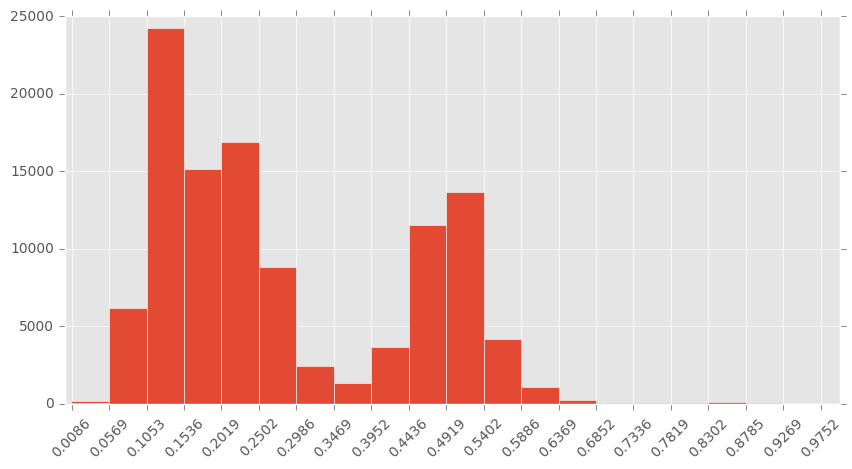

In [33]:
# Subset to make it faster for testing
ja_reps_matrix_ = ja_reps_matrix[0:10]

# TODO: Try different distance metrics?
sim = cdist(ja_reps_matrix_, en_reps_matrix, metric='hamming')
sim = np.nan_to_num(sim)

fig = plt.figure(figsize=(10,5))
_, bins, _ = plt.hist(sim.flatten(), bins=20)
plt.xticks(bins, rotation=45)
# print(sim.shape)
# match_idx = np.argmin(sim)
# match_idx = np.unravel_index(match_idx, sim.shape)
# print(sim[match_idx])

# print(ja_reps_keys[match_idx[0]])
# print(en_reps_keys[match_idx[1]])
pd.Series(sim.flatten()).describe()

In [71]:
# TODO: Tune this
THRESHOLD = 0.04
DIST_METRIC = "hamming"

matches = []
for ja_idx, ja_sub_vector in itertools.islice(enumerate(ja_reps_matrix), 10000):
  dists = cdist([ja_sub_vector], en_reps_matrix, metric=DIST_METRIC)[0]
  best_en_idx = np.argmin(dists)
  best_dist = dists[best_en_idx]
  if best_dist < THRESHOLD:
    matches.append((ja_reps_keys[ja_idx], en_reps_keys[best_en_idx], score))

print("Found {} matches.".format(len(matches)))    

Found 1159 matches.


In [73]:
OUTPUT_DIR = "/Users/dennybritz/Downloads/daddicts_matched"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Optional:
# # Organize matched files
# for idx, match in enumerate(matches):
#   ja_file, en_file, score = match
#   output_dir = os.path.join(OUTPUT_DIR, str(idx))
#   os.makedirs(output_dir, exist_ok=True)
#   shutil.copy2(ja_file, output_dir)
#   shutil.copy2(en_file, output_dir)

In [74]:
RAW_OUTPUT_PATH_EN = "/Users/dennybritz/Downloads/daddicts_matched/combined.en"
RAW_OUTPUT_PATH_JA = "/Users/dennybritz/Downloads/daddicts_matched/combined.ja"

raw_output_file_en = open(RAW_OUTPUT_PATH_EN, "w")
raw_output_file_ja = open(RAW_OUTPUT_PATH_JA, "w")

def text_filter(ja_text, en_text):
  if len(ja_text) < 3 or len(en_text) < 5:
    return False
  return True

for match in matches:
  ja_file, en_file, score = match
  match_events_ja = ja_events[ja_file]
  match_events_en = en_events[en_file]

  # For each JA event find closest EN event
  for ja_event in match_events_ja:
    closest_event_en = min(match_events_en, key=lambda x: np.abs(ja_event.start_sec - x.start_sec))
    ja_text = ja_event.text.replace("\n", " ").strip()
    en_text = closest_event_en.text.replace("\n", " ").strip()
    
    if not text_filter(ja_text, en_text):
      continue
    
    raw_output_file_en.write(en_text + "\n")
    raw_output_file_ja.write(ja_text + "\n")
    
raw_output_file_en.close()
raw_output_file_ja.close()

In [49]:
np.abs(3)

3